# Model Validation

Need a method to determine if identified model has captured the dynamics of the system

Need to pick the number of poles and zeros

We will look at residual analysis

# Expression for the Prediction Error

In order to develop the validation algorithm, we need to recall the expression for the prediction error. This expression will give us some interesting insights.

Consider a model with plant model $G(q,\theta)$ and noise model $H(q,\theta)$ (the structure of $G(q,\theta)$, and $H(q,\theta)$ could be ARX, OE, or BJ for intance). Then the prediction error is:
$$
\begin{align*}
\varepsilon(t,\theta) &= y(t)-\hat{y}(t|t-1,\theta) \\
&= y(t)-H^{-1}(q,\theta)G(q,\theta)u(t)-(1-H^{-1}(q,\theta))
\end{align*}
$$

Let the data generating system by represented as: $y(t) = G^0(q)u(t) + v(t)$. Using this expression we get:
$$
\begin{align*}
\varepsilon(t,\theta) &= H^{-1}(q,\theta) (G^0(q)u(t) + v(t)-G(q,\theta)u(t))   \\
 &=  H^{-1}(q,\theta) (G^0(q)u(t) -G(q,\theta)u(t) + v(t))  \\
&=  H^{-1}(q,\theta) (G^0(q)-G(q,\theta))u(t) + H^{-1}(q,\theta)v(t) + e(t), 
\end{align*}
$$
where $\Delta G(q,\theta) = G^0(q) - G(q,\theta)$.
Now we wish to analyse this expression from a statistical point of view. 

We make the same assumptions as before:
- the noise $v(t) = H_0(q)e(t)$, where $e$ is a sequence of independant, identically distributed random variables, which means that $e(t)$ is uncorrelated to $e(t-\tau)$ for all $\tau$ except $\tau=0$, 
- the input $u$ and the process noise $e$ are uncorrelated. This means that $E[u(t)e(t-\tau)]=0$ for all $\tau$.
 




# Main Idea - Determining if the model has captured the plant dynamics

If we have a model that captures the "true" plant dynamics we have $\Delta G = G(\theta) - G=0$. When $\Delta G=0$, the expression for the prediction error is:
$$
\begin{align*}
\varepsilon(t,\theta) = H^{-1}(q,\theta)v(t).
\end{align*}
$$

The key observation is: the above expression for the prediction error is uncorrelated to $u$.

Thus, we can conclude: if the prediction error is uncorrelated to $u$, then we have captured the true plant dynamics. Now we want to construct a test to check whether $u$ is uncorrelated to $\varepsilon(t,\theta)$.

# Idea

Let's calculate the cross-correlation of the prediction error of a given model, and the input $u$, and see if it is zero, or at least "small". 

In [1]:
import control as ct
import numpy as np
import scipy as sp  
import matplotlib.pyplot as plt
import sysid_pem as sid

In [2]:
def generate_data(B0,C0,D0,F0,N,sigma_v):
    u = np.random.randn(N)
    e = np.random.randn(N)
    H0 = ct.tf(C0,D0,True)
    tt,v = ct.forced_response(H0,U=e)
    G0 = ct.tf(B0,F0,True)
    tt,y = ct.forced_response(G0,U=u)
    y = y + sigma_v*v
    return u, y

In [3]:
# Generate Data

N = 1001
t = np.linspace(0,10,N)
Ts = t[1]-t[0]
fs = 1/Ts
sigma_v = 0.1

# Data Generating System
F0 = np.real(np.convolve([1, -0.95+0.15j],[1, -0.95-0.15j]))
B0 = np.array([2, 0.7, -0.9])
C0 = [1, -0.4]
D0 = [1, -0.9]

G0 = ct.tf(B0, F0, Ts)
H0 = ct.tf(C0,D0,Ts)


u,y = generate_data(B0,C0,D0,F0,N,sigma_v)

In [5]:
# Identify a model using Box-Jenkins model structure

nf = 2
nb = 3
nc = 1
nd = 1
na = nf
nk = 0

n_bj = [nb, nc, nd, nf, nk]

n_high_order = [30,30]
theta_init_bj = sid.get_initial_estimate_box_jenkins(n_bj,n_high_order,y,u) 
optimization_results = sp.optimize.least_squares(sid.V_box_jenkins, theta_init_bj, jac=sid.jac_V_bj, args=(n_bj,y,u))

G_hat_box_jenkins,H_hat_box_jenkins=sid.theta_2_tf_box_jenkins(optimization_results.x,n_bj,Ts)
y_hat = sid.y_hat_box_jenkins(optimization_results.x,n_bj,y,u)
epsilon = y-y_hat

print('\n\nBox Jenkins Model Structure:')
print('Estimated G:')
print(G_hat_box_jenkins)
print('Estimated H:')
print(H_hat_box_jenkins)



Box Jenkins Model Structure:
Estimated G:

2.005 z^2 + 0.6932 z - 0.8958
-----------------------------
    z^2 - 1.9 z + 0.9249

dt = 0.01

Estimated H:

z - 0.4444
----------
z - 0.9071

dt = 0.01



Text(0.5, 0, 'Lag (samples)')

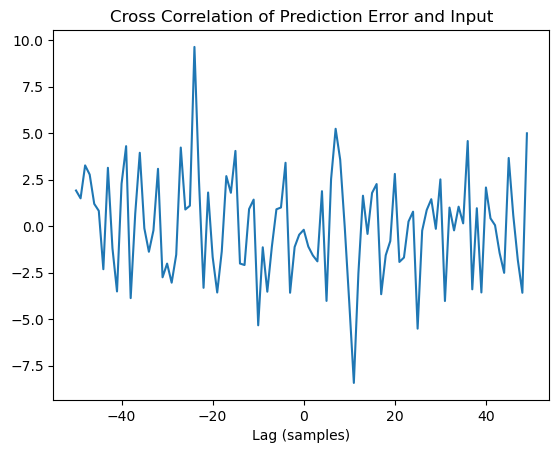

In [5]:
# Look at cross-correlation between input and prediction error

Reu = np.correlate(epsilon,u,'full')
tau = 50
Reu = Reu[N-tau:N+tau]

fig,ax = plt.subplots(1)
ax.plot(np.arange(-tau,tau),Reu)

ax.set_title('Cross Correlation of Prediction Error and Input')
ax.set_xlabel('Lag (samples)')

# Observation

It is very difficult to tell if this cross correlation is zero, or not. For finite data length, the cross-correlation will never be exactly zero. So how can we determine if it is close enough to zero?

Need to calculate confidence bounds. See Chapter 6 posted on D2L for a derivation of the confidence bounds. 

We can use the bounds as follows. 
# If 
$$
| R_{\varepsilon u}(\tau) | \le \sqrt{\frac{P}{N}}N_{\alpha},
$$
where $P = \sum_{\tau=-\infty}^{\infty} R_{\epsilon}(\tau)R_u(\tau)$ and $N_{\alpha}$ is determined by the confidence level that we want to use. For a $95$% confidence level we select $N_{\alpha}=1.95$ (this comes from the normal distribution).
# Then
we can can say: "I am 95% confident that the cross-correlation between $u$ and $\varepsilon$ is zero."

It follows that we can say: "I am 95% confident that I have captured the plant dynamics".


Use the above code. Change the plant model change the noise model see when the cross correlation of the input and the prediction errors are with in the bounds, and when they are not. 

Text(0.5, 0, 'Lag (samples)')

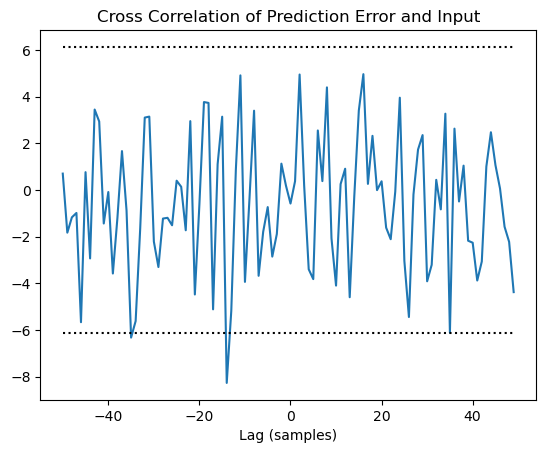

In [6]:
# Look at cross-correlation between input and prediction error

Reu = np.correlate(epsilon,u,'full')
tau = 50
Reu = Reu[N-tau:N+tau]

# Calculate the bound
Re = np.correlate(epsilon,epsilon,'full')
Ru = np.correlate(u,u,'full')
P = np.sum(Re*Ru)
bound = np.sqrt(P/N)*1.95 # 95% confidence bounds


fig,ax = plt.subplots(1)
ax.plot(np.arange(-tau,tau),Reu)
ax.plot(np.arange(-tau,tau),np.ones(2*tau)*bound,'k:')
ax.plot(np.arange(-tau,tau),-np.ones(2*tau)*bound,'k:')
ax.set_title('Cross Correlation of Prediction Error and Input')
ax.set_xlabel('Lag (samples)')


# Try Different Model Orders - What do you see?


In [12]:
# Identify a model using Box-Jenkins model structure

nf = 2
nb = 3
nc = 0
nd = 1
na = nf
nk = 0

n_bj = [nb, nc, nd, nf, nk]

n_high_order = [30,30]
theta_init_bj = sid.get_initial_estimate_box_jenkins(n_bj,n_high_order,y,u) 
optimization_results = sp.optimize.least_squares(sid.V_box_jenkins, theta_init_bj, jac=sid.jac_V_bj, args=(n_bj,y,u))

G_hat_box_jenkins,H_hat_box_jenkins=sid.theta_2_tf_box_jenkins(optimization_results.x,n_bj,Ts)
y_hat = sid.y_hat_box_jenkins(optimization_results.x,n_bj,y,u)
epsilon = y-y_hat

print('\n\nBox Jenkins Model Structure:')
print('Estimated G:')
print(G_hat_box_jenkins)
print('Estimated H:')
print(H_hat_box_jenkins)



Box Jenkins Model Structure:
Estimated G:

2.005 z^2 + 0.6926 z - 0.8948
-----------------------------
    z^2 - 1.9 z + 0.9249

dt = 0.01

Estimated H:

    z
---------
z - 0.743

dt = 0.01



Text(0.5, 0, 'Lag (samples)')

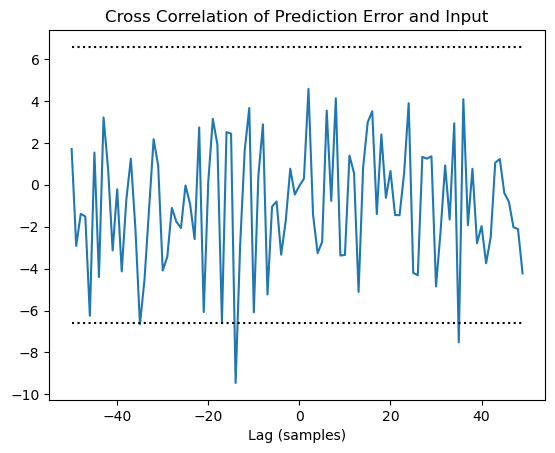

In [13]:
# Look at cross-correlation between input and prediction error

Reu = np.correlate(epsilon,u,'full')
tau = 50
Reu = Reu[N-tau:N+tau]

# Calculate the bound
Re = np.correlate(epsilon,epsilon,'full')
Ru = np.correlate(u,u,'full')
P = np.sum(Re*Ru)
bound = np.sqrt(P/N)*1.95 # 95% confidence bounds


fig,ax = plt.subplots(1)
ax.plot(np.arange(-tau,tau),Reu)
ax.plot(np.arange(-tau,tau),np.ones(2*tau)*bound,'k:')
ax.plot(np.arange(-tau,tau),-np.ones(2*tau)*bound,'k:')
ax.set_title('Cross Correlation of Prediction Error and Input')
ax.set_xlabel('Lag (samples)')


# Conclusion

For data collected in open loop, if we pass the residual test, then we are 95 \% confident that $u$ and $v$ are uncorrelated, so therefore, we are 95 \% confident that our estimated plant model has the same dynamics as the plant of the data generating system.  

# What about checking if we have the correct noise model?

Again, we will develop a test based on properties of the prediction error for a given estimated model (defined by $\theta$). 

Consider a model with plant model $G(q,\theta)$ and noise model $H(q,\theta)$ (the structure of $G(q,\theta)$, and $H(q,\theta)$ could be ARX, OE, or BJ for intance). Then the prediction error is:
$$
\begin{align*}
\varepsilon(t,\theta) &= y(t)-\hat{y}(t|t-1,\theta) \\
&= y(t)-H^{-1}(q,\theta)G(q,\theta)u(t)-(1-H^{-1}(q,\theta))
\end{align*}
$$

Let the data generating system by represented as: $y(t) = G^0(q)u(t) + H^0(q)e(t)$. Using this expression we get:
$$
\begin{align*}
\varepsilon(t,\theta) &= H^{-1}(q,\theta) (G^0(q)u(t) + H^0(q)e(t)-G(q,\theta)u(t))   \\
 &=  H^{-1}(q,\theta) (G^0(q)u(t) -G(q,\theta)u(t) + H^0(q)e(t) + H(q,\theta)e(t)- H(q,\theta)e(t))  \\
&=  H^{-1}(q,\theta) \bigg ( (G^0(q)-G(q,\theta))u(t) + (H^0(q)-H(q,\theta))e(t) \bigg) + e(t) \\
& =  H^{-1}(q,\theta) \Delta G(q,\theta)u(t) + H^{-1}(q,\theta) \Delta H(q,\theta)e(t)  + e(t) , 
\end{align*}
$$
where $\Delta G(q,\theta) = G^0(q) - G(q,\theta)$, and $\Delta H(q,\theta) = H^0(q) - H(q,\theta)$
Now we wish to analyse this expression from a statistical point of view. 

We make the same assumptions as before:
- the input $u$ and the process noise $e$ are uncorrelated. This means that $E[u(t)e(t-\tau)]=0$ for all $\tau$, 
- the noise $e$ is a sequence of independant, identically distributed random variables, which means that $e(t)$ is uncorrelated to $e(t-\tau)$ for all $\tau$ except $\tau=0$.  

Suppose that we have a model that has the same plant dynamics as the data generating system, then we have $\Delta G = G(\theta) - G=0$. If the model also captures the noise dynamics of the data generating system, then $\Delta H = H(\theta) - H=0$. 

When $\Delta G=0$ and $\Delta H = 0$, the expression for the prediction error is:
$$
\begin{align*}
\varepsilon(t,\theta) = e(t).
\end{align*}
$$



# The key observation is

The above expression for the prediction error is white noise.

Thus, we can conclude: if the prediction error is white noise, then we have captured the plant and noise dynamics of the data generating system. Now we want to construct a test to check whether $\varepsilon(t,\theta)$ is white noise.

# Idea

Let's calculate the auto-correlation of the prediction error of a given model and see if it is zero, or at least "small" for lags greater than $0$. 

# Observation

Similar to before, it will be very difficult to tell if this auto correlation is zero, or not. For finite data length, the auto-correlation will never be exactly zero. So how can we determine if it is close enough to zero?

Need to calculate confidence bounds. See Chapter 6 posted on D2L for a derivation of the confidence bounds. 

We can use the bounds as follows. 
# If 
$$
| \frac{R_{\varepsilon}(\tau)}{R_{\varepsilon}(0) }| \le \sqrt{\frac{1}{N}}N_{\alpha},
$$
where $N_{\alpha}$ is determined by the confidence level that we want to use. For a $95$% confidence level we select $N_{\alpha}=1.95$ (this comes from the normal distribution).
# Then
we can can say: "I am 95% confident that the auto-correlation of $\varepsilon$ is zero for $\tau>0$."

It follows that we can then say: "I am 95% confident that I have captured the plant and noise dynamics.


# Try it yourself

Take some time with the code below. Try different combinations of the correct and incorrect parameterizations of the plant and noise model. It is important to see how the residual tests work.

In [8]:
# Identify a model using Box-Jenkins model structure

nf = 2
nb = 3
nc = 1
nd = 1
na = nf
nk = 0

n_bj = [nb, nc, nd, nf, nk]

n_high_order = [30,30]
theta_init_bj = sid.get_initial_estimate_box_jenkins(n_bj,n_high_order,y,u) 
optimization_results = sp.optimize.least_squares(sid.V_box_jenkins, theta_init_bj, jac=sid.jac_V_bj, args=(n_bj,y,u))

G_hat_box_jenkins,H_hat_box_jenkins=sid.theta_2_tf_box_jenkins(optimization_results.x,n_bj,Ts)
y_hat = sid.y_hat_box_jenkins(optimization_results.x,n_bj,y,u)
epsilon = y-y_hat

print('\n\nBox Jenkins Model Structure:')
print('Estimated G:')
print(G_hat_box_jenkins)
print('Estimated H:')
print(H_hat_box_jenkins)



Box Jenkins Model Structure:
Estimated G:

2.001 z^2 + 0.6968 z - 0.895
----------------------------
    z^2 - 1.9 z + 0.925

dt = 0.01

Estimated H:

z - 0.4116
----------
z - 0.897

dt = 0.01



Text(0.5, 0, 'Lag (samples)')

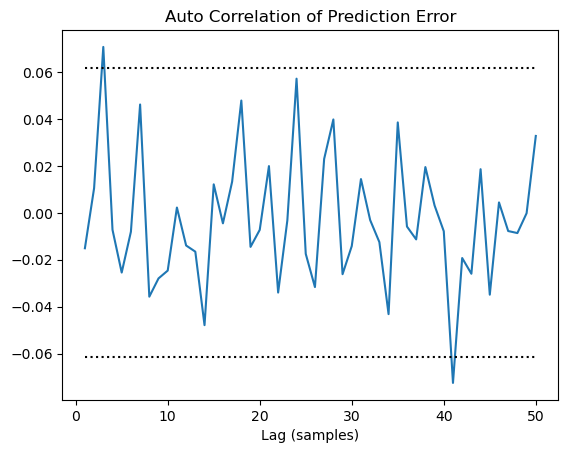

In [9]:
# Look at auto-correlation of prediction error

Re = np.correlate(epsilon,epsilon,'full')

tau = 50
Re_pos = Re[N:N+tau]

bound_e = 1.95/np.sqrt(N)

fig,ax = plt.subplots(1)
ax.plot(np.arange(1,tau+1),Re_pos/Re[N-1])
ax.plot(np.arange(1,tau+1),np.ones(tau)*bound_e,'k:')
ax.plot(np.arange(1,tau+1),-np.ones(tau)*bound_e,'k:')
ax.set_title('Auto Correlation of Prediction Error')
ax.set_xlabel('Lag (samples)')